# Testing RF Terrains

In [5]:
import pandas as pd
import numpy as np 
import rasterio
import rioxarray
import matplotlib.pyplot as plt 
import xarray as xr
import math
import seaborn as sns
sns.set()
sns.set_context("notebook")

class Analysis:
    def __init__(self) -> None:
        pass
    
    def __sub__(self, other):
        return self.test_data - other.test_data  

    
    def get_rf_results(self, rf_results):
        self.rf_results = rioxarray.open_rasterio(rf_results, band_as_variable=True)
        
    def set_ground_truth(self, gt_tif):
        self.gt = rioxarray.open_rasterio(gt_tif, band_as_variable=True)
        return self.gt

    def set_test_data(self, test_data_tif):
        self.test_data = rioxarray.open_rasterio(test_data_tif, band_as_variable=True)
        return self.test_data
    
    def get_difference(self):
        self.ground_truth = self.gt.rio.reproject_match(self.test_data)
        self.difference = self.test_data - self.ground_truth 
    

    def calc_rmse(self):
        diff = self.test_data - self.ground_truth
        diff_sq = diff ** 2
        mean = diff_sq.band_1.mean()
        rmse = math.sqrt(mean)
        return rmse

In [6]:
taranaki_ground_truth = "../ICESAT/nzealand/gnd_taranaki.tif"
gcanyon_ground_truth = "../ICESAT/gcanyon/gnd_gcaynon.tif"
limburg_ground_truth = "../ICESAT/zlimburg/gnd_eu_dem.tif"
icepts = "../ICESAT/gcanyon/grand_canyon.csv"
icepts = pd.read_csv(icepts)

# Assuming your CSV file has columns named 'x', 'y', and 'z'
x = icepts['lon'].values
y = icepts['lat'].values

# Grand Canyon w Model-NL
gc_modelNL = Analysis()
gc_modelNL.set_ground_truth(gcanyon_ground_truth)
gc_modelNL.set_test_data("../ICESAT/gcanyon/results/gcanyon_pred_modelNL.tif")
gc_modelNL.get_difference()

# Grand Canyon w Model-NZ
gc_modelNZ = Analysis()
gc_modelNZ.set_ground_truth(gcanyon_ground_truth)
gc_modelNZ.set_test_data("../ICESAT/gcanyon/results/gcanyon_pred_modelNZ.tif")
gc_modelNZ.get_difference()

# Grand Canyon w Model-GC
gc_modelGC = Analysis()
gc_modelGC.set_ground_truth(gcanyon_ground_truth)
gc_modelGC.set_test_data("../ICESAT/gcanyon/results/gcanyon_pred_sklearn.tif")
gc_modelGC.get_difference()


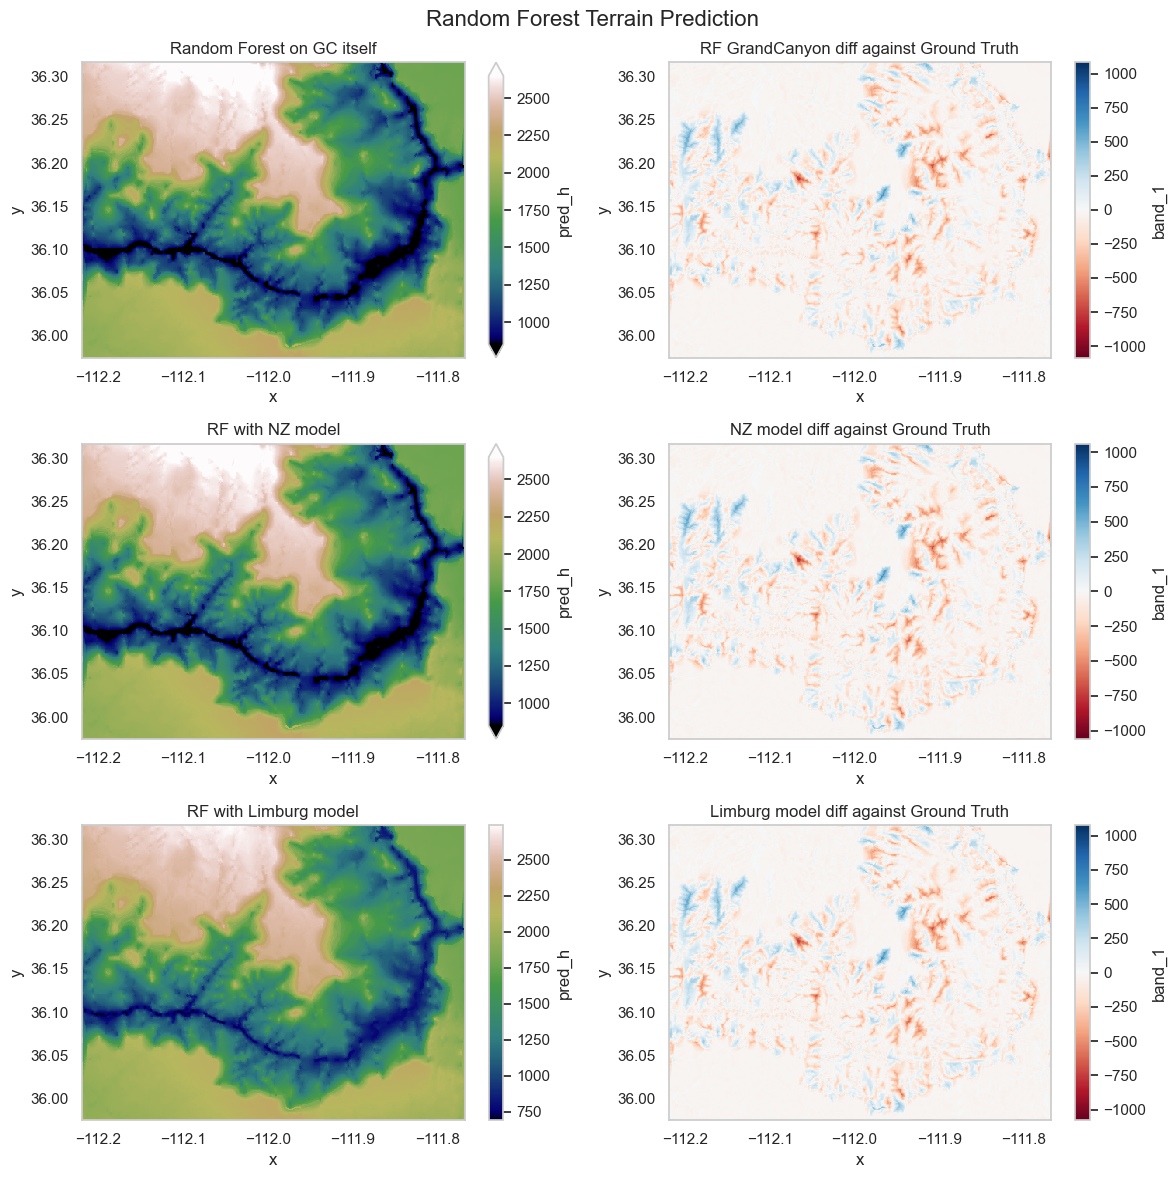

In [15]:
# gc_modelGC.difference.band_1.plot(cmap='RdBu', robust=True)
# plt.scatter(x,y, s=0.1, alpha=0.1)
# plt.show()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

gc_modelGC.test_data.band_1.plot(cmap='gist_earth', robust=True, ax=axes[0,0])
axes[0,0].set_title('Random Forest on GC itself')

gc_modelGC.difference.band_1.plot(cmap='RdBu', ax=axes[0,1])
axes[0,1].set_title('RF GrandCanyon diff against Ground Truth')

gc_modelNZ.test_data.band_1.plot(cmap='gist_earth', robust=True, ax=axes[1,0])
axes[1,0].set_title('RF with NZ model')

gc_modelNZ.difference.band_1.plot(cmap='RdBu', ax=axes[1,1])
axes[1,1].set_title('NZ model diff against Ground Truth')

gc_modelNL.test_data.band_1.plot(cmap='gist_earth', ax=axes[2,0])
axes[2,0].set_title('RF with Limburg model')

gc_modelNL.difference.band_1.plot(cmap='RdBu', ax=axes[2,1])
axes[2,1].set_title('Limburg model diff against Ground Truth')

# Adjust space between subplots
plt.suptitle("Random Forest Terrain Prediction", fontsize=16)
plt.tight_layout()
plt.show()




In [8]:
# gc_modelGC.difference.band_1.plot(cmap='RdBu', robust=True)
# plt.scatter(x,y, s=0.1, alpha=0.1)
# plt.show()
## RMSE Calculation
print(gc_modelGC.calc_rmse())
print(gc_modelNL.calc_rmse())
print(gc_modelNZ.calc_rmse())




108.77535913863565
108.60715746117282
108.77826462480355


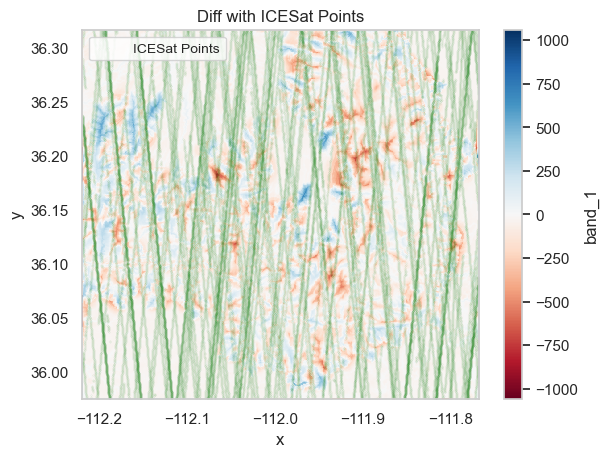

In [9]:
sns.set_style("whitegrid")

gc_modelNZ.difference.band_1.plot(cmap='RdBu')
plt.scatter(x, y, marker='.', c='green', s=0.1, label='ICESat Points', alpha=0.2)
plt.legend(loc='upper left', fontsize='small')
plt.title("Diff with ICESat Points")
plt.show()


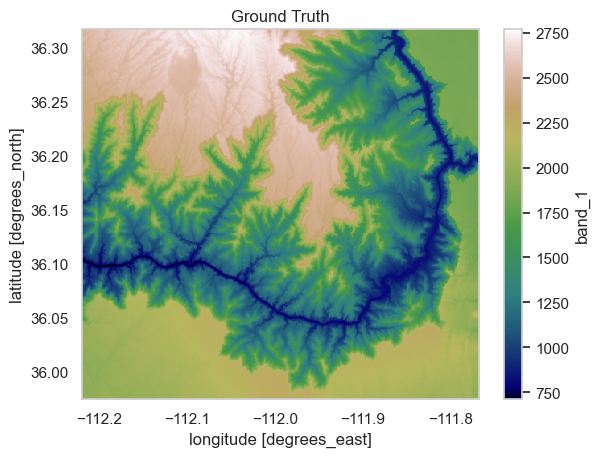

In [10]:
gc_modelNZ.ground_truth.band_1.plot(cmap='gist_earth')
plt.title("Ground Truth")
plt.show()


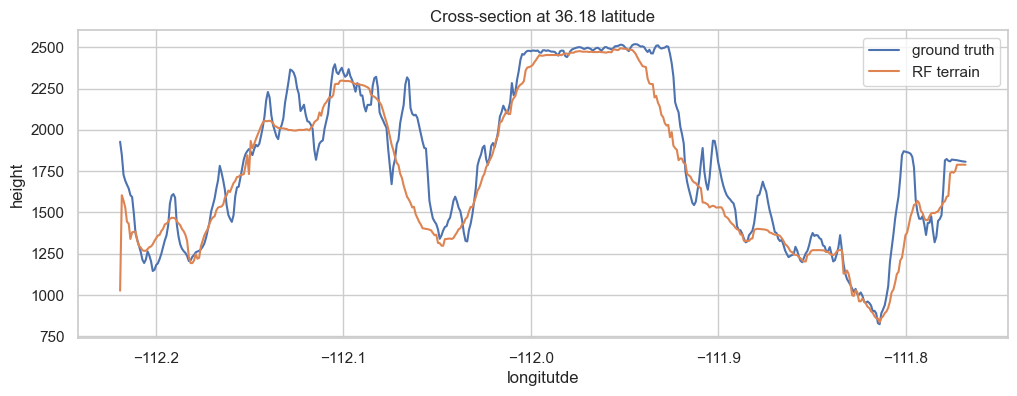

<Figure size 10200x1000 with 0 Axes>

In [11]:
sns.set_style('whitegrid')

cross_section_gnd = gc_modelNZ.ground_truth.sel(y=36.18, method='nearest')
cross_section_gc = gc_modelNZ.test_data.sel(y=36.18, method='nearest')
fig = plt.figure(figsize=(12, 4))

cross_section_gnd.band_1.plot(label="ground truth")
cross_section_gc.band_1.plot(label="RF terrain")


plt.legend()
plt.xlabel('longitutde')
plt.ylabel('height')
plt.title('Cross-section at 36.18 latitude')
plt.figure(figsize=(102, 10))
plt.show()


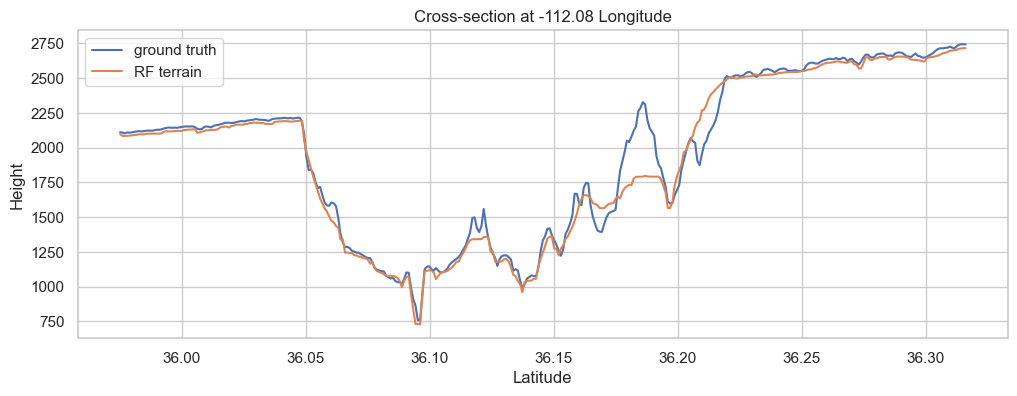

<Figure size 10200x1000 with 0 Axes>

In [12]:
cross_section_gnd = gc_modelNZ.ground_truth.sel(x=-112.07, method='nearest')
cross_section_gc = gc_modelNZ.test_data.sel(x=-112.07, method='nearest')
fig = plt.figure(figsize=(12, 4))

cross_section_gnd.band_1.plot(label="ground truth")
cross_section_gc.band_1.plot(label="RF terrain")


plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Height')
plt.title('Cross-section at -112.08 Longitude')
plt.figure(figsize=(102, 10))
plt.show()


In [13]:
# import numpy as np
# import scipy.ndimage
# import matplotlib.pyplot as plt

# #-- Generate some data...
# ground_truth = rioxarray.open_rasterio("../ICESAT/gcanyon/gnd_gcaynon.tif", band_as_variable=True)
# cross_array = rioxarray.open_rasterio("../ICESAT/gcanyon/results/gcanyon_pred_modelNL.tif", band_as_variable=True)
# ground_truth = ground_truth.rio.reproject_match(cross_array)
# print(ground_truth.band_1.shape)


# #-- Extract the line...
# # Make a line with "num" points...
# x0, y0 = 0, 300 # These are in _pixel_ coordinates!!
# x1, y1 = 200, 300
# num = 1500
# x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)

# # Extract the values along the line, using cubic interpolation
# zi = scipy.ndimage.map_coordinates(cross_array.band_1, np.vstack((x,y)))
# zy = scipy.ndimage.map_coordinates(ground_truth.band_1, np.vstack((x,y)))

# #-- Plot...
# fig, axes = plt.subplots(nrows=2)
# axes[0].imshow(cross_array.band_1)
# axes[0].plot([x0, x1], [y0, y1], 'b-')
# axes[0].axis('image')

# axes[1].plot(zi)
# axes[1].plot(zy)

# plt.show()
